# Waves Prediction With Gated Recurrent Units (GRU)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Data import
df = pd.read_csv('/kaggle/input/waves-measuring-buoys-data-mooloolaba/Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv')
df.head(8)

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,01/01/2017 00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
1,01/01/2017 00:30,0.875,1.39,4.421,4.506,-99.9,-99.90
2,01/01/2017 01:00,0.763,1.15,4.520,5.513,49.0,25.65
3,01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
4,01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45
5,01/01/2017 02:30,0.718,1.61,4.614,6.181,68.0,25.45
6,01/01/2017 03:00,0.707,1.34,4.568,4.705,73.0,25.50
7,01/01/2017 03:30,0.729,1.21,4.786,4.484,63.0,25.50


## Data Preprocessing

### Checking for Missing Values
- In first place, we check for the presence of null data in the dataset.


In [2]:
# Present dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43728 entries, 0 to 43727
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date/Time       43728 non-null  object 
 1   Hs              43728 non-null  float64
 2   Hmax            43728 non-null  float64
 3   Tz              43728 non-null  float64
 4   Tp              43728 non-null  float64
 5   Peak Direction  43728 non-null  float64
 6   SST             43728 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.3+ MB


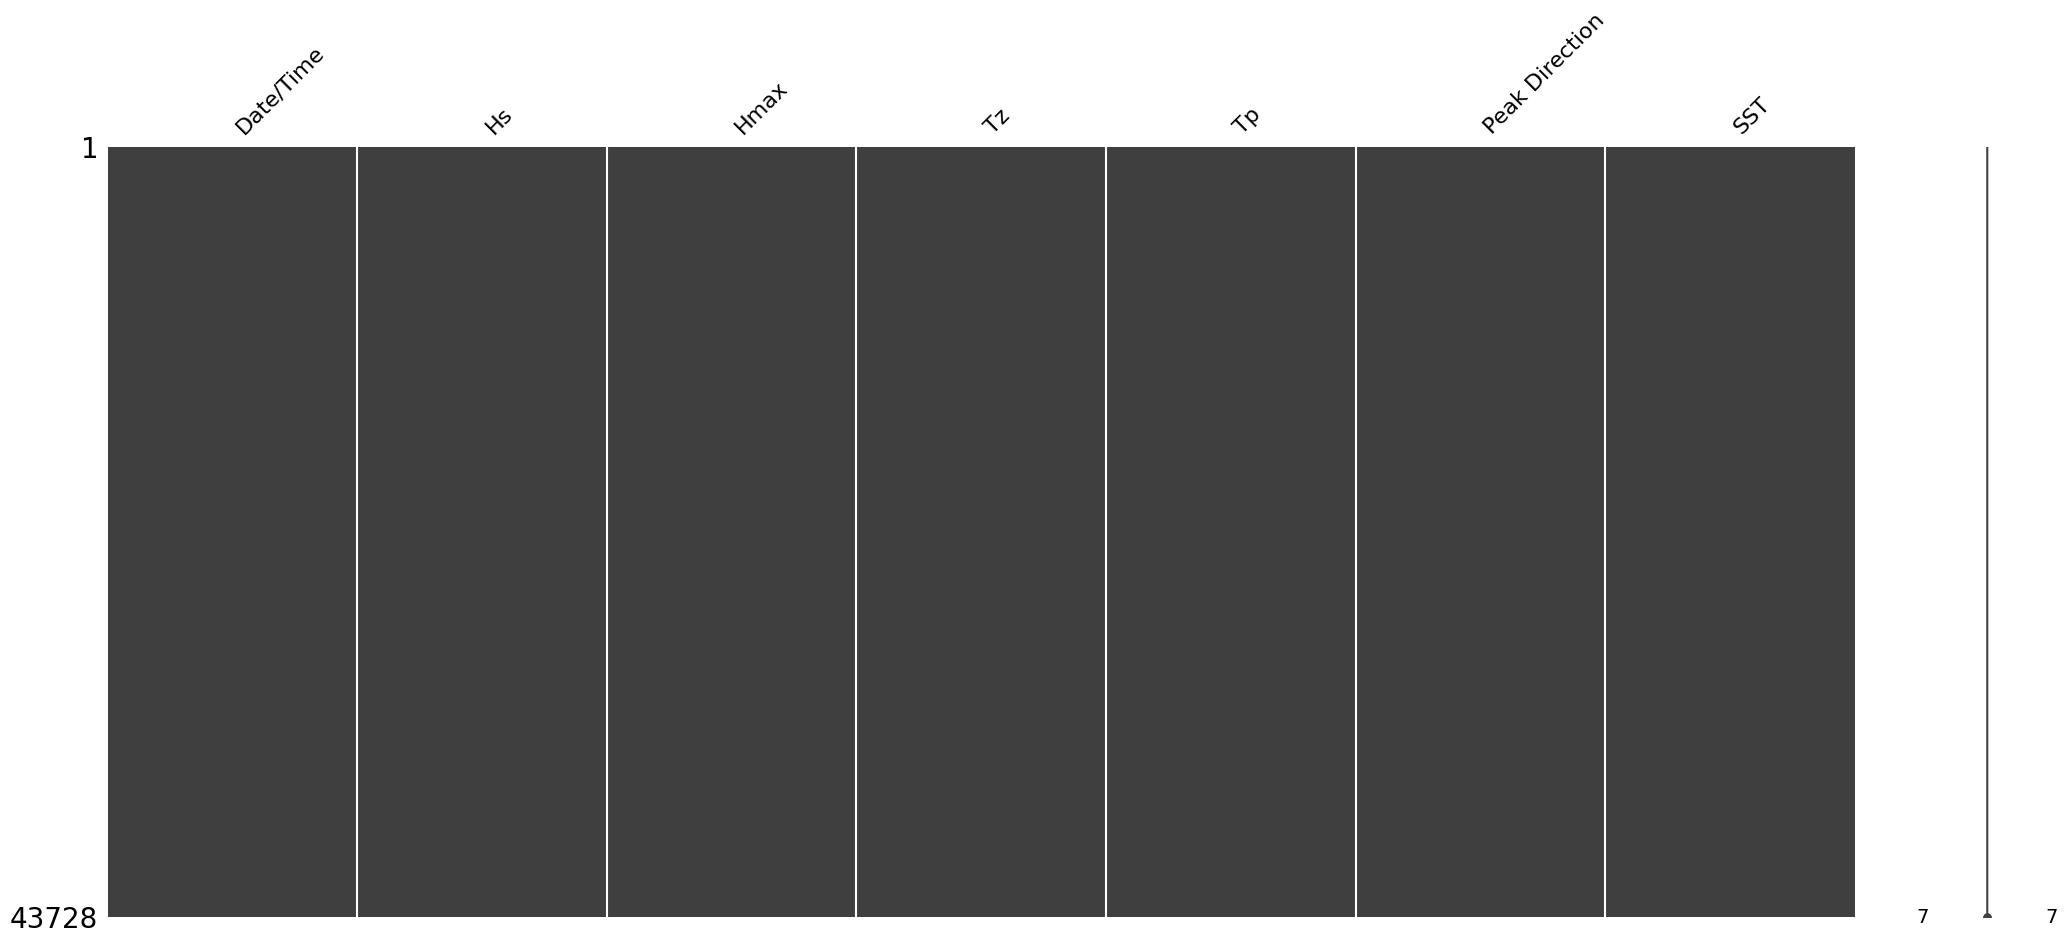

<Figure size 1500x900 with 0 Axes>

In [3]:
# Null data for each feature
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

### Spurious Data Analysis
- We have identified the presence of spurious values for the features of the dataset, particularly the value -99.9, which is impossible to occur within the context of this problem.
- However, this spurious data represents only 0.63% of the total dataset. Therefore, the best approach to handling these spurious values is to delete them from the dataset.


In [4]:
df[(df == -99.9 ).any(axis=1)] # Spurious Data

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,01/01/2017 00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
1,01/01/2017 00:30,0.875,1.39,4.421,4.506,-99.9,-99.90
40,01/01/2017 20:00,1.266,2.20,4.404,4.809,-99.9,25.45
853,1/18/2017 18:30,1.073,1.96,4.036,4.233,-99.9,26.70
1554,02/02/2017 09:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
...,...,...,...,...,...,...,...
43125,18/06/2019 10:30,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
43126,18/06/2019 11:00,0.576,0.87,6.693,13.726,-99.9,-99.90
43127,18/06/2019 11:30,0.611,1.05,6.386,13.801,-99.9,-99.90
43237,20/06/2019 18:30,1.173,1.82,4.707,9.343,-99.9,21.40


In [5]:
# Spurious Data Percentage
print('Spurious Data Percentage: ',round(df[(df == -99.9).any(axis=1)].shape[0] * 100 / df.shape[0],2), '%')

Spurious Data Percentage:  0.63 %


In [6]:
df = df.drop(df[(df == -99.9).any(axis=1)].index) # Delete the negative values from the dataset

In [7]:
df.head()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
2,01/01/2017 01:00,0.763,1.15,4.520,5.513,49.0,25.65
3,01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
4,01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45
5,01/01/2017 02:30,0.718,1.61,4.614,6.181,68.0,25.45
6,01/01/2017 03:00,0.707,1.34,4.568,4.705,73.0,25.50


### Date Time Processing
- It is important to ensure that the date/time column is sorted. Because, there is no guarantee that the data is already sorted by date and time.
- We can observe that the date and time values for the years 2017 and 2018 are in the format %m/%d/%y, while the values for the year 2019 are in the format %d/%m/%y. Therefore, it is necessary to reformat these values.

In [8]:
df[df['Date/Time'].str.contains('2017')].tail()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
17515,12/31/2017 21:30,0.539,1.07,4.884,9.277,80.0,26.45
17516,12/31/2017 22:00,0.534,0.94,4.740,10.201,92.0,26.40
17517,12/31/2017 22:30,0.514,0.79,4.768,10.249,97.0,26.40
17518,12/31/2017 23:00,0.539,0.89,4.792,10.144,84.0,26.40
17519,12/31/2017 23:30,0.520,0.96,4.970,9.696,88.0,26.35


In [9]:
df[df['Date/Time'].str.contains('2018')].tail()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
35035,12/31/2018 21:30,1.389,2.09,6.028,8.990,75.0,25.65
35036,12/31/2018 22:00,1.460,2.55,5.913,8.573,68.0,25.65
35037,12/31/2018 22:30,1.495,2.79,5.794,8.829,61.0,25.60
35038,12/31/2018 23:00,1.379,2.26,5.901,8.643,70.0,25.60
35039,12/31/2018 23:30,1.460,2.49,6.041,8.536,74.0,25.55


In [10]:
df[df['Date/Time'].str.contains('2019')].tail()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
43723,30/06/2019 21:30,2.299,3.60,9.281,12.765,94.0,21.95
43724,30/06/2019 22:00,2.075,3.04,9.303,12.722,95.0,21.95
43725,30/06/2019 22:30,2.157,3.43,9.168,12.890,97.0,21.95
43726,30/06/2019 23:00,2.087,2.84,8.706,10.963,92.0,21.95
43727,30/06/2019 23:30,1.926,2.98,8.509,12.228,84.0,21.95


In [11]:
df['Date/Time_Aux'] = df['Date/Time'].apply(lambda x: len(x)) # Aux column for date time len 

In [12]:
df['Date/Time_Aux'].unique() # Display the different values for the date time len

array([16, 14, 15])

In [13]:
df[(df['Date/Time_Aux'] == 14)] # date time values with len 14

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST,Date/Time_Aux
576,1/13/2017 0:00,0.894,1.45,5.939,8.860,95.0,26.40,14
577,1/13/2017 0:30,0.953,1.70,6.141,8.867,101.0,26.40,14
578,1/13/2017 1:00,0.896,1.52,6.187,8.662,105.0,26.35,14
579,1/13/2017 1:30,0.896,1.84,6.100,8.863,98.0,26.35,14
580,1/13/2017 2:00,1.018,1.60,6.544,8.543,102.0,26.35,14
...,...,...,...,...,...,...,...,...
30591,9/30/2018 7:30,0.811,1.61,4.854,7.065,53.0,21.55,14
30592,9/30/2018 8:00,0.839,1.44,4.466,7.602,42.0,21.55,14
30593,9/30/2018 8:30,0.949,1.76,4.465,8.496,46.0,21.60,14
30594,9/30/2018 9:00,1.025,1.53,4.337,4.029,132.0,21.55,14


In [14]:
df['Date/Time'] = df['Date/Time'].str.replace(' ', '/').str.split('/') # Split date time data

# Define a function to replace the element at the specified index
def replace_element(lst):
    
    month = lst[0] # month value
    day = lst[1] # day value
    year = lst[2] # year value
    hour = lst[3] # time value
    
    if len(month) == 1: # Correct the month length
        month = '0' + month
        
    if len(day) == 1:# Correct the day length
        day = '0' + day
        
    if len(hour) == 4: # Correct the time length
        hour = '0' + hour
        
    if year == '2019': # Reformat the date time values for year 2019
        
        return day + '/' + month + '/' + year + ' ' + hour

    else:
        
        return month + '/' + day + '/' + year + ' ' + hour # Return fixed date time values

# Update the date time values 
df['Date/Time'] = df['Date/Time'].apply(replace_element)


In [15]:
# Check the date time values 
df['Date/Time_Aux'] = df['Date/Time'].apply(lambda x: len(x))
df['Date/Time_Aux'].unique()

array([16])

In [16]:
# Convert Date Time column to datetime type
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Sort the Dataset by Date/Time column
df_sorted = df.sort_values(by='Date/Time')

In [17]:
df.head() # Sorted Dataset

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST,Date/Time_Aux
2,2017-01-01 01:00:00,0.763,1.15,4.520,5.513,49.0,25.65,16
3,2017-01-01 01:30:00,0.770,1.41,4.582,5.647,75.0,25.50,16
4,2017-01-01 02:00:00,0.747,1.16,4.515,5.083,91.0,25.45,16
5,2017-01-01 02:30:00,0.718,1.61,4.614,6.181,68.0,25.45,16
6,2017-01-01 03:00:00,0.707,1.34,4.568,4.705,73.0,25.50,16


In [18]:
df = df.drop(columns = ['Date/Time','Date/Time_Aux']) # Delete the date time values
df.head()

,Hs,Hmax,Tz,Tp,Peak Direction,SST
2,0.763,1.15,4.520,5.513,49.0,25.65
3,0.770,1.41,4.582,5.647,75.0,25.50
4,0.747,1.16,4.515,5.083,91.0,25.45
5,0.718,1.61,4.614,6.181,68.0,25.45
6,0.707,1.34,4.568,4.705,73.0,25.50


### Normalizing Feature Data
- Given the varying scales of features, it's necessary to normalize the data.

In [19]:
float_data = df.to_numpy() # Dataset to numpy array

#mean = float_data.mean(axis = 0) # Get mean value for the features

#float_data -= mean # Set mean = 0

#std = float_data.std(axis = 0) # Get the standard deviation

#float_data /= std # Set standard deviation = 1

In [20]:
from sklearn.preprocessing import MinMaxScaler

# Scaling all the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(float_data)
print('Shape of the scaled data matrix: ', data.shape)

Shape of the scaled data matrix:  (43454, 6)


In [21]:
data # Normalized data

array([[0.11834469, 0.08653326, 0.18406628, 0.15178523, 0.12464589,
        0.66101695],
       [0.12011103, 0.1216874 , 0.19196941, 0.15906744, 0.19830028,
        0.6440678 ],
       [0.11430734, 0.08788534, 0.18342894, 0.12841693, 0.24362606,
        0.63841808],
       ...,
       [0.47009841, 0.394808  , 0.77654557, 0.55268735, 0.26062323,
        0.24293785],
       [0.45243502, 0.31503515, 0.71765456, 0.44796478, 0.24645892,
        0.24293785],
       [0.41180924, 0.33396431, 0.69254302, 0.51671105, 0.22379603,
        0.24293785]])

### Data split
- We split the data into training and testing sets, and set a lookback step of 48 (one day).

In [64]:
data.shape

(43454, 6)

In [65]:
# Separete data into 2 groups for train and test
train = data[:36000,]
test = data[36001: ,]

# Shapes of our datasets
print('Train data: ', train.shape)
print('Test data: ', test.shape)

Train data:  (36000, 6)
Test data:  (7453, 6)


In [66]:
def data_split(data):
    
    lookback = 24 # Observation will go back 1/2 days
    
    x_list = [] 
    y_list = []
    
    for i in range(0, len(data) - lookback, lookback): 
        
        x_list.append(data[i: i + lookback]) # Append the lookback data
        
        y_list.append(data[i + lookback]) # Append the target data
                
    X_data = np.array(x_list) 
    
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[2], X_data.shape[1])) # Reshape train data
    
    y_data = np.array(y_list)
    
    return X_data, y_data 

In [67]:
# Executing the separation
X_train, y_train = data_split(train)
X_test, y_test = data_split(test)
print('X_train Shape : ', X_train.shape, 'y_train shape :', y_train.shape)
print('X_test Shape  : ', X_test.shape, ' y_test shape  :', y_test.shape)

X_train Shape :  (1499, 6, 24) y_train shape : (1499, 6)
X_test Shape  :  (310, 6, 24)  y_test shape  : (310, 6)


### Model
- Initially, we applied a naive model that predicts the next timestep based on the mean of the lookback values. This approach establishes a baseline that we need to surpass.
- Then, we trained a densely connected model, a simple and cost-effective machine learning model. This was done to ensure that any further complexity is justified by a benefit. 
- Finally, we trained a Gated Recurrent Unit (GRU) to predict the data. This model presents a stack of recurrent layers, as well as recurrent dropout to reduce overfitting.
- The chosen metric for comparing predictions is the mean absolute error.

In [121]:
def evaluate_naive_method(data): #Naive prediction
    
    lookback = 24 # Observation will go back half a day
   
    Score_Hs = []
    Score_Hmax = []
    Score_Tz = []
    Score_Tp = []
    Score_Dir = []
    Score_SST = []
    naive_pred = []
    
    data = scaler.inverse_transform(data) # Inverse transform the data
    
    for i in range(0, len(data) - lookback, lookback):
        
        preds = data[i :i + lookback] # Get the x_values 
        
        targets = data[i + lookback] # Get the target value
        
        # Set the prediction as the mean value for each feature and calculate the mean absolute error
        Score_Hs.append(np.abs(np.mean(preds[:,0]) - targets[0])) 
        Score_Hmax.append(np.abs(np.mean(preds[:,1]) - targets[1]))
        Score_Tz.append(np.abs(np.mean(preds[:,2]) - targets[2]))
        Score_Tp.append(np.abs(np.mean(preds[:,3]) - targets[3]))
        Score_Dir.append(np.abs(np.mean(preds[:,4]) - targets[4]))
        Score_SST.append(np.abs(np.mean(preds[:,5]) - targets[5]))
        
        # append the prediction fot he i + lookback timestep of the naive model
        naive_pred.append(np.mean(preds, axis = 0)) 
        
    naive_pred = np.array(naive_pred) # Convert to array
    
    naive_model = []
    
    # Save the mean absolute error for each feature
    naive_model.append(round(np.mean(Score_Hs),3))
    naive_model.append(round(np.mean(Score_Hmax),3))
    naive_model.append(round(np.mean(Score_Tz),3))
    naive_model.append(round(np.mean(Score_Tp),3))
    naive_model.append(round(np.mean(Score_Dir),3))
    naive_model.append(round(np.mean(Score_SST),3))
    
    # Print the mean absolute error for each feature
    print('MAE_Hs       : ', round(np.mean(Score_Hs),3), '[m]')
    print('MAE_Hmax     : ', round(np.mean(Score_Hmax),3), '[m]')
    print('MAE_Tz       : ', round(np.mean(Score_Tz),3), '[s]')
    print('MAE_Tp       : ', round(np.mean(Score_Tp),3), '[s]')
    print('MAE_Direction: ', round(np.mean(Score_Dir),3), '[°]')
    print('MAE_SST      : ', round(np.mean(Score_SST),3), '[°C]')
    
    # Return the errors and the predictions of the naive model
    return naive_model, naive_pred 
        
naive_model_mae, naive_pred = evaluate_naive_method(train) # Train the naive prediction 

MAE_Hs       :  0.12 [m]
MAE_Hmax     :  0.253 [m]
MAE_Tz       :  0.372 [s]
MAE_Tp       :  0.993 [s]
MAE_Direction:  9.457 [°]
MAE_SST      :  0.149 [°C]


In [95]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import layers

# Basic densely connected network
def naive_model(x_data, y_data, num_epochs, batch_size, learning_rate): 
    
    model = Sequential() # Initializing the model
    
    model.add(layers.Flatten(input_shape=(x_data.shape[1], x_data.shape[2]))) # Adding the first layer
    
    model.add(layers.Dense(32, activation=None)) # Adding a dense layer
    
    model.add(layers.Dense(6))# Adding the output layer
    
    optimizer = Adam(learning_rate=learning_rate) # Set the optimizer
    
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error']) # Compiling the model
    
    # Fitting the model
    history = model.fit(x_data, y_data, 
                        validation_split = 0.2,
                        epochs = num_epochs, batch_size = batch_size)
    
    return model, history

In [96]:
history_dense = naive_model(X_train, y_train, num_epochs=30, batch_size=32, learning_rate=.001)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2885 - mean_absolute_error: 0.2885 - val_loss: 0.0811 - val_mean_absolute_error: 0.0811
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0824 - mean_absolute_error: 0.0824 - val_loss: 0.0656 - val_mean_absolute_error: 0.0656
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0680 - mean_absolute_error: 0.0680 - val_loss: 0.0559 - val_mean_absolute_error: 0.0559
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0604 - mean_absolute_error: 0.0604 - val_loss: 0.0600 - val_mean_absolute_error: 0.0600
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0587 - mean_absolute_error: 0.0587 - val_loss: 0.0506 - val_mean_absolute_error: 0.0506
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0527 - mean_absolute_error: 0.0527 - val_loss: 0.0499 - val_mean_absolute_error: 0.0499
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0499 - mean_absolute_error: 0.0499 - val_loss: 0.0473 - val_me

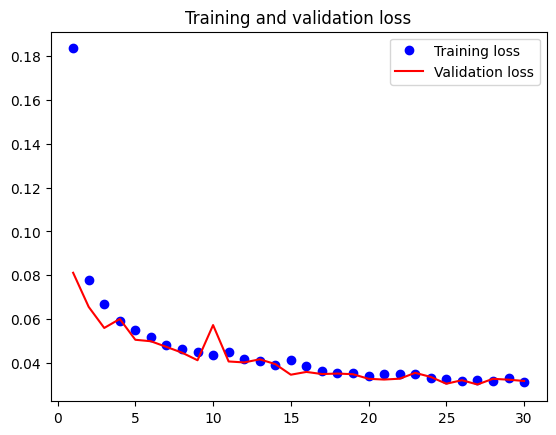

In [97]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
loss = history_dense[1].history['loss'] # Training loss

val_loss = history_dense[1].history['val_loss'] # Validation loss

epochs = range(1, len(loss) + 1) # epochs range

# Plot figure
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [108]:
def GRU_model(x_data, y_data, num_epochs, batch_size, learning_rate):
    
    model = Sequential() # Initializing the model
    
    model.add(layers.GRU(64,
            dropout=0.1,
            recurrent_dropout=0.1,
            return_sequences=True,
            input_shape=(x_data.shape[1], x_data.shape[2]))) # First GRU layer

    model.add(layers.GRU(32, activation=None,
            dropout=0.1,
            recurrent_dropout=0.1)) # Stacking the second GRU layer

    model.add(layers.Dense(6)) # Add the output layer
    
    # Choosing the optimizer
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compiling the model
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

    # Fitting the model
    history = model.fit(x_data, y_data, 
                        validation_split=0.2, 
                        epochs=num_epochs, batch_size=batch_size)

    return model, history

In [109]:
history_GRU = GRU_model(X_train, y_train, num_epochs=30, batch_size=32, learning_rate=.001)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.2143 - mean_absolute_error: 0.2143 - val_loss: 0.0535 - val_mean_absolute_error: 0.0535
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0879 - mean_absolute_error: 0.0879 - val_loss: 0.0466 - val_mean_absolute_error: 0.0466
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0735 - mean_absolute_error: 0.0735 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0644 - mean_absolute_error: 0.0644 - val_loss: 0.0441 - val_mean_absolute_error: 0.0441
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0612 - mean_absolute_error: 0.0612 - val_loss: 0.0396 - val_mean_absolute_error: 0.0396
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0589 - mean_absolute_error: 0.0589 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0557 - mean_absolute_error: 0.0557 - val_loss: 0.0361 - 

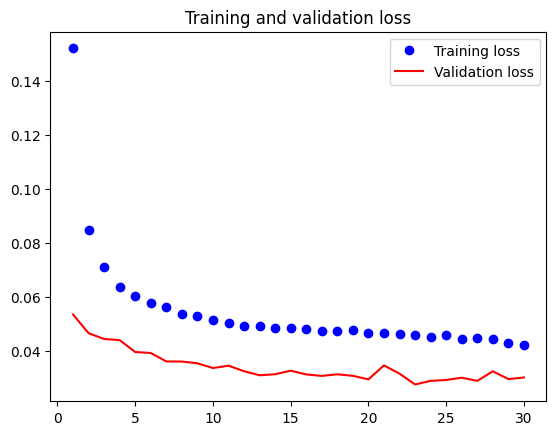

In [113]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
loss = history_GRU[1].history['loss'] # Training loss

val_loss = history_GRU[1].history['val_loss'] # Validation loss

epochs = range(1, len(loss) + 1) # epochs range

# Plot figure
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [114]:
# Defining function to predict datas
def predicting(data, y_real, history):
    
    predicted_data = history[0].predict(data) # Get the predicted data
    
    # Invert scaling process to get the normal values range for the features 
    predicted_data = scaler.inverse_transform(predicted_data)
    y_real = scaler.inverse_transform(y_real) 
    
    return predicted_data, y_real

In [115]:
# Executing predictions
test_prediction_GRU, y_real = predicting(X_test, y_test, history = history_GRU)
test_prediction_dense, y_real = predicting(X_test, y_test, history = history_dense)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [116]:
# Defining function to investigate the root of mean absolute errors (MAE) between predicted and real data

import math
from sklearn.metrics import mean_absolute_error

def examine_mae(y_data, predicted_data):
    
    # Calculated the mean absolute error for each feature
    Score_Hs = round(mean_absolute_error(y_data[:,0], predicted_data[:,0]),3)
    Score_Hmax = round(mean_absolute_error(y_data[:,1], predicted_data[:,1]),3)
    Score_Tz = round(mean_absolute_error(y_data[:,2], predicted_data[:,2]),3)
    Score_Tp = round(mean_absolute_error(y_data[:,3], predicted_data[:,3]),3)
    Score_Dir = round(mean_absolute_error(y_data[:,4], predicted_data[:,4]),3)
    Score_SST = round(mean_absolute_error(y_data[:,5], predicted_data[:,5]),3)
    
    # Save the mean absolute error for each feature
    model_mae = [Score_Hs, Score_Hmax, Score_Tz, Score_Tp, Score_Dir, Score_SST]   
    
    #Print the mean absolute error for each feature
    print('MAE_Hs       : ', Score_Hs)
    print('MAE_Hmax     : ', Score_Hmax)
    print('MAE_Tz       : ', Score_Tz)
    print('MAE_Tp       : ', Score_Tp)
    print('MAE_Direction: ', Score_Dir)
    print('MAE_SST      : ', Score_SST)
    
    return model_mae

In [122]:
naive_model_mae, naive_pred = evaluate_naive_method(test) # Test the naive prediction

MAE_Hs       :  0.107 [m]
MAE_Hmax     :  0.225 [m]
MAE_Tz       :  0.35 [s]
MAE_Tp       :  1.058 [s]
MAE_Direction:  7.903 [°]
MAE_SST      :  0.137 [°C]


In [117]:
# GRU test 
print('GRU Test Data Errors')
GRU_model_error = examine_mae(y_real, test_prediction_GRU)

GRU Test Data Errors
MAE_Hs       :  0.075
MAE_Hmax     :  0.196
MAE_Tz       :  0.251
MAE_Tp       :  0.99
MAE_Direction:  7.272
MAE_SST      :  0.483


In [118]:
# Dense Model test
print('Dense Test Data Errors')
model_dense_mae = examine_mae(y_real, test_prediction_dense)

Dense Test Data Errors
MAE_Hs       :  0.101
MAE_Hmax     :  0.245
MAE_Tz       :  0.261
MAE_Tp       :  1.216
MAE_Direction:  8.09
MAE_SST      :  0.218


In [119]:
# Trasnform the test predictions
naive_model_mae = np.array(naive_model_mae)
GRU_model_error = np.array(GRU_model_error)

# Create a dataframe for the mean absolute error for each model and feature
df_mae = pd.DataFrame(
    {'Feature': df.columns,
    'Naive_Model': naive_model_mae,
     'Dense_model': model_dense_mae,
     'GRU_Model': GRU_model_error,
     #'Difference Percentage (%)': ((GRU_model - naive_model_mae) * 100 / naive_model_mae).round(2)
    })

df_mae

,Feature,Naive_Model,Dense_model,GRU_Model
0,Hs,0.107,0.101,0.075
1,Hmax,0.225,0.245,0.196
2,Tz,0.350,0.261,0.251
3,Tp,1.058,1.216,0.990
4,Peak Direction,7.903,8.090,7.272
5,SST,0.137,0.218,0.483


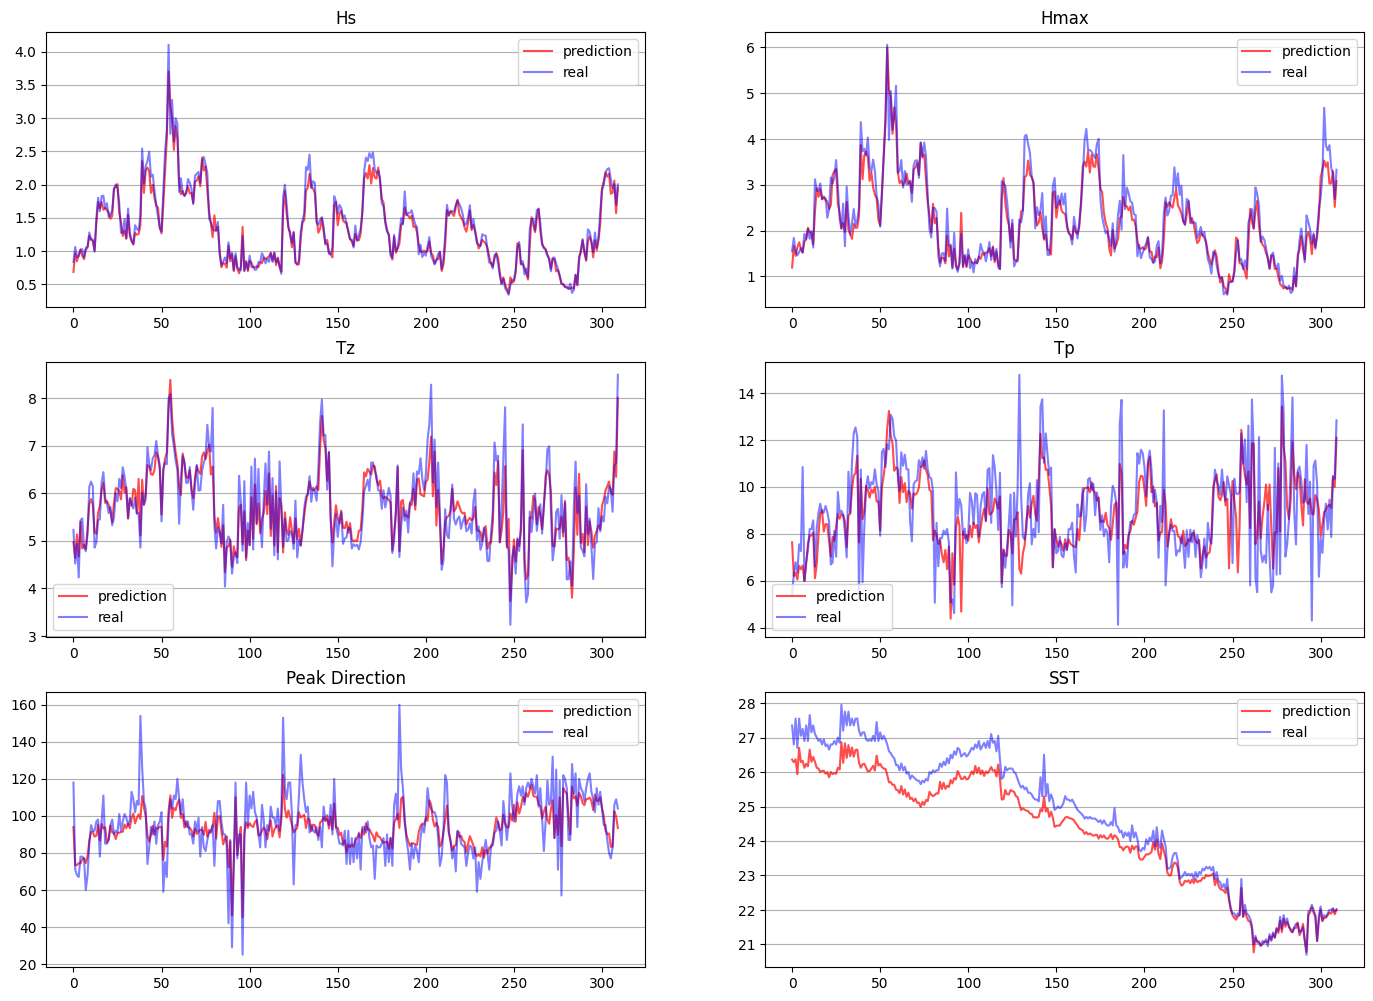

In [120]:
# Plot the GRU predictions vs the real values

plt.figure(figsize=(17,25))

prediction = test_prediction_GRU

for i in range(0,len(df.columns)):

    plt.subplot(6,2,i + 1)
    plt.plot(prediction[:,i], color='red', alpha=0.7, label='prediction')
    plt.plot(y_real[:,i], color='blue', alpha=0.5, label='real')
    plt.title(df.columns[i])
    plt.legend()
    plt.grid(axis='y')

## Conclusions

##### In the first place, we observe that the GRU model exhibits lower mean absolute error compared to the other two models for the training data. Which justifies the addition of complexity to the model, because present a notorious benefit to the predictions.

##### On the other hand, for the test dataset, the GRU model also shows a lower mean absolute error for almost all features. However, for the feature related to surface water temperature, the GRU model exhibits a higher mean absolute error compared with the other models.

##### In conclusion, the best-performing model considering mean absolute error is the GRU model, which outperforms the basic models used as baselines. The only detail of the model is the feature related to surface water temperature, where it performs worse compared to the other two models.